In [2]:
import numpy as np
import pandas as pd
from methods import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product
import seaborn as sn

## Read questionnaire information from picking procedure

In [3]:
questionnaires = data_handler.get_questionaires("data2/questionaires_shuffled.pickle")
labels = data_handler.get_labels()

Using downloaded and verified file: .\data/imagenet_class_index.json


In [4]:
def get_label_from_img_idx(img_idx, testset_path, labels):    
    img_folder = datasets.ImageFolder(root=testset_path)
    img_path = img_folder.imgs[img_idx][0]
    img_name = img_path.split(os.sep)[-1]
    # extract correct class
    class_idx_true_str = img_path.split(os.sep)[-2]
    img_label_true = labels[class_idx_true_str][1]
    return img_label_true

In [5]:
# enrich questionnaire data with image label names
questionnaires_2 = []
for questionnaire in tqdm(questionnaires):
    questionnaire_2 = []
    for question in questionnaire:
        label = get_label_from_img_idx(question[0], "data2/imagenetv2-matched-frequency-format-val", labels)
        question_labled = (label, ) + question        
        questionnaire_2.append(question_labled)
    questionnaires_2.append(questionnaire_2) 

100%|██████████| 12/12 [00:43<00:00,  3.61s/it]


## Load question codes used in SoSci

In [6]:
codes_list = []
for i in range(1, 12+1):
    codes = pd.read_csv(f"questionaires_shuffle_order/questionaire_{i}.txt", sep=";", names=[0, 1])[1]
    codes = codes.str.extract("(\w\d{3})")
    codes = list(codes[0])
    codes_list.append(codes)

## Create questions meta data df

In [7]:
df_quest_meta = pd.DataFrame(list(chain(*questionnaires_2)))
df_quest_meta[5] = list(chain(*codes_list))
df_quest_meta.columns = ["label", "img_idx", "model", "method", "is_pred_correct", "question_code"]

In [8]:
df_quest_meta

,label,img_idx,model,method,is_pred_correct,question_code
0,custard_apple,9521,vgg,LRP,True,B108
1,Boston_bull,1073,vgg,SHAP,True,B111
2,toilet_tissue,9992,alex,IntegratedGradients,False,B118
3,gas_pump,5253,vgg,ConfidenceScores,False,B123
4,mailbag,5976,vgg,IntegratedGradients,False,B124
...,...,...,...,...,...,...
283,custard_apple,9521,vgg,gradCAM,True,C307
284,coral_reef,9710,alex,gradCAM,True,C302
285,black_grouse,7798,alex,LRP,False,C319
286,steel_arch_bridge,8034,alex,SHAP,True,C317


## Load and transform questionnaire data

In [11]:
# data_tu-helpfulness-of-xai_2022-06-21_17-15.xlsx
df = pd.read_excel("data2/data_tu-helpfulness-of-xai_2022-06-29_10-48.xlsx")
# delete column descriptions
df = df.drop(0)

In [12]:
def convert_q_data_from_wide_to_long(df):
    df_long = pd.melt(df, id_vars="CASE", value_vars=df.columns.values[6:294]).dropna()
    df_long.columns = ["case", "question_code", "response"]
    df_long = df_long.sort_values("case", )
    # map response 1(Yes)/2(No) values to True/False
    df_long["response"] = df_long["response"].apply(lambda x: True if x==1 else False) 
    return df_long

In [13]:
df_long = convert_q_data_from_wide_to_long(df)

In [14]:
df_long

,case,question_code,response
21488,579,B715,False
22168,579,B720,True
22032,579,B719,True
21896,579,B718,False
21760,579,B717,True
...,...,...,...
25295,1660,B818,True
25567,1660,B820,True
25703,1660,B821,False
25975,1660,B823,False


# Analysis

In [15]:
df_merged = df_long.merge(right=df_quest_meta)
df_merged = df_merged.sort_values("case")

In [16]:
df_merged

,case,question_code,response,label,img_idx,model,method,is_pred_correct
0,579,B715,False,chiffonier,4389,alex,SHAP,True
210,579,B702,False,matchstick,6063,vgg,ConfidenceScores,False
200,579,B703,True,gyromitra,9931,alex,LIME,True
30,579,B718,False,trifle,9200,alex,ConfidenceScores,False
190,579,B704,False,Boston_bull,1073,alex,SHAP,False
...,...,...,...,...,...,...,...,...
2219,1660,B817,True,red-breasted_merganser,9788,alex,ConfidenceScores,False
2327,1660,B801,False,custard_apple,9521,alex,SHAP,True
2207,1660,B822,False,shovel,7702,vgg,gradCAM,False
2159,1660,B810,False,coral_reef,9710,vgg,SHAP,True


## Confusion Matrices

### Overall all confusion matrix

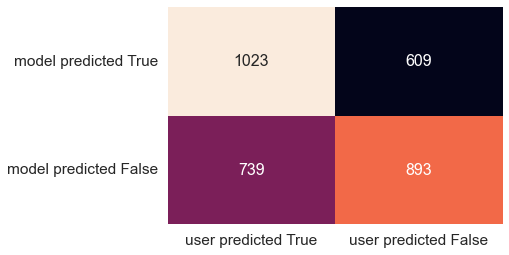

Accuracy is 0.5870098039215687


In [17]:
TP = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == True)]
TN = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == False)]
FN = df_merged[(df_merged["is_pred_correct"] == True) & (df_merged["response"] == False)]
FP = df_merged[(df_merged["is_pred_correct"] == False) & (df_merged["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

### Model wise confusion matrix

#### VGG

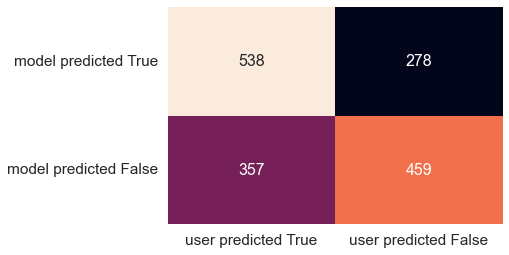

Accuracy is 0.6109068627450981


In [18]:
tmp = df_merged[df_merged["model"]=="vgg"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### AlexNet

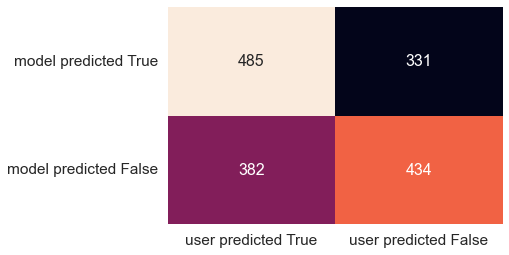

Accuracy is 0.5631127450980392


In [19]:
tmp = df_merged[df_merged["model"]=="alex"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

### Method wise

#### LRP

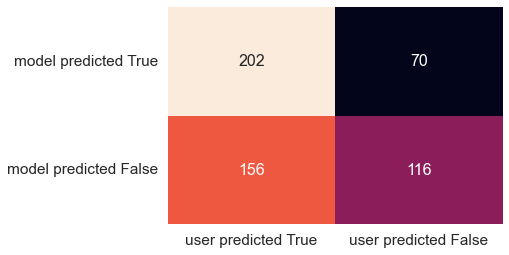

Accuracy is 0.5845588235294118


In [20]:
tmp = df_merged[df_merged["method"]=="LRP"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### gradcam

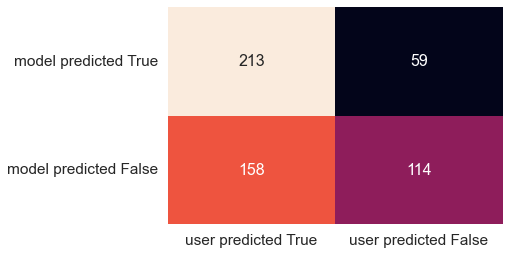

Accuracy is 0.6011029411764706


In [21]:
tmp = df_merged[df_merged["method"]=="gradCAM"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### LIME

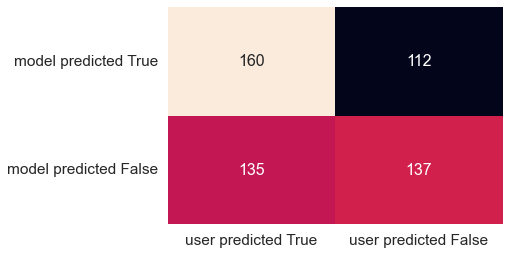

Accuracy is 0.5459558823529411


In [22]:
tmp = df_merged[df_merged["method"]=="LIME"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### SHAP

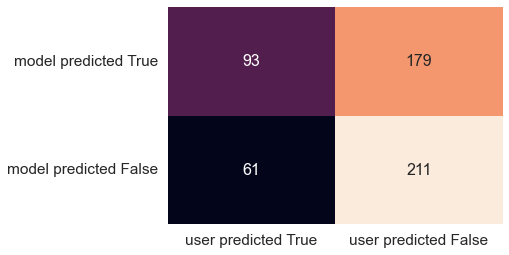

Accuracy is 0.5588235294117647


In [23]:
tmp = df_merged[df_merged["method"]=="SHAP"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### ConfidenceScores

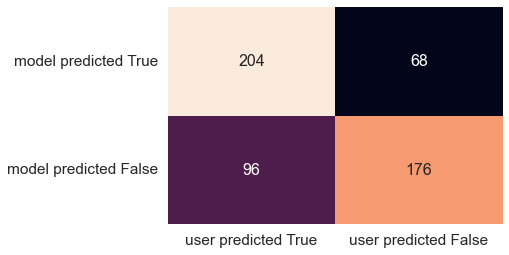

Accuracy is 0.6985294117647058


In [24]:
tmp = df_merged[df_merged["method"]=="ConfidenceScores"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### IntegratedGradients

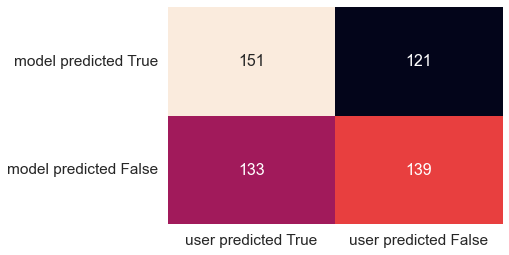

Accuracy is 0.5330882352941176


In [25]:
tmp = df_merged[df_merged["method"]=="IntegratedGradients"]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

### Questionaire wise

#### Questionaire 1

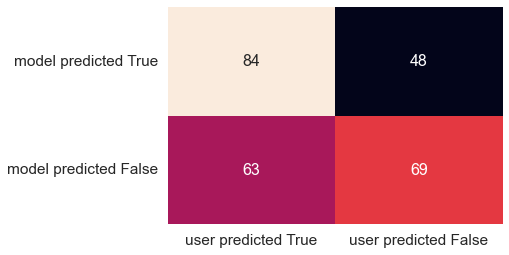

Accuracy is 0.5795454545454546


In [26]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B1" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 2

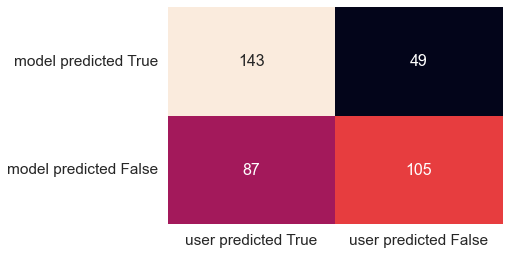

Accuracy is 0.6458333333333334


In [27]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B2" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 3

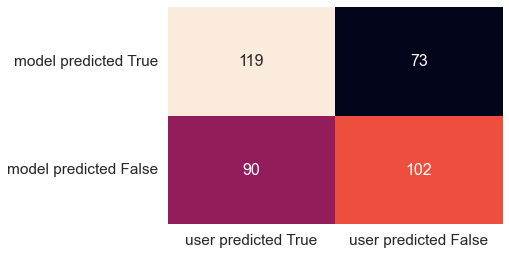

Accuracy is 0.5755208333333334


In [28]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B3" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 4

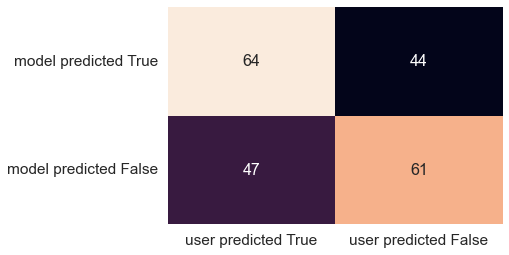

Accuracy is 0.5787037037037037


In [29]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B4" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 5

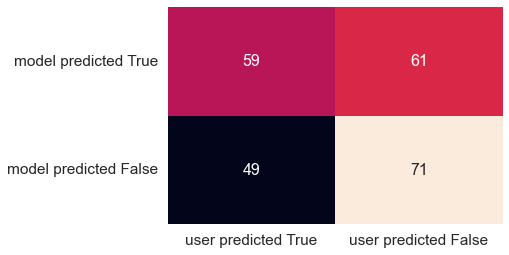

Accuracy is 0.5416666666666666


In [30]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B5" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 6

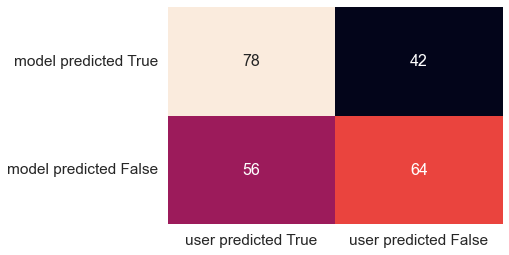

Accuracy is 0.5916666666666667


In [31]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B6" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 7

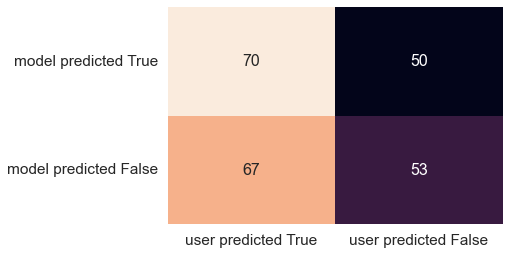

Accuracy is 0.5125


In [32]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B7" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 8

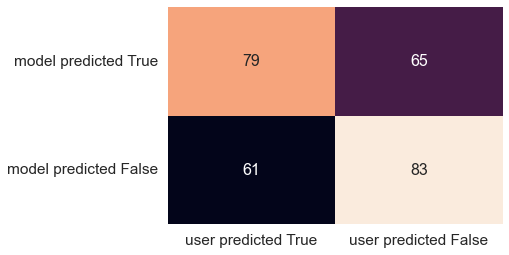

Accuracy is 0.5625


In [33]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B8" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 9

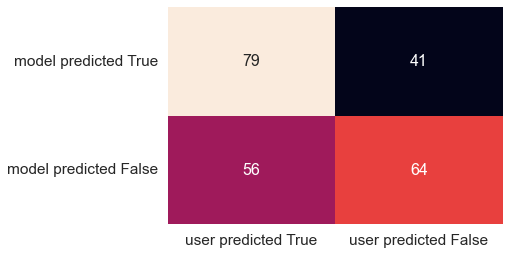

Accuracy is 0.5958333333333333


In [34]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "B9" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 10

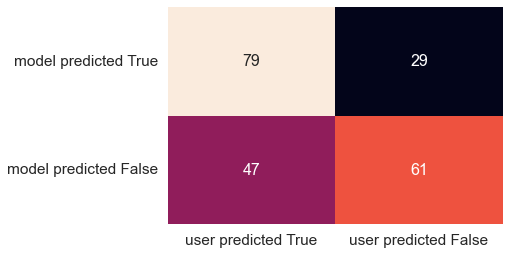

Accuracy is 0.6481481481481481


In [35]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "C1" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 11

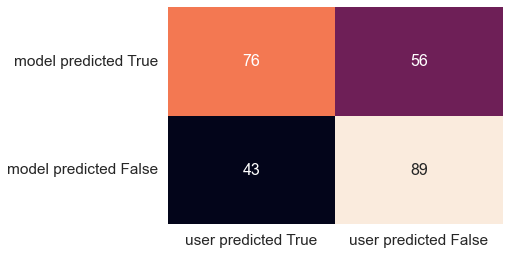

Accuracy is 0.625


In [36]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "C2" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

#### Questionaire 12

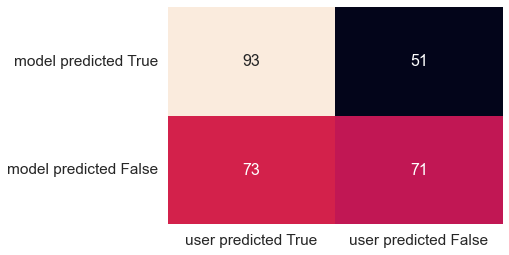

Accuracy is 0.5694444444444444


In [37]:
tmp = df_merged[df_merged["question_code"].apply(lambda x: "C3" in x)]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

### Fixed Questions

In [38]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]
df_merged_fixed = df_long.merge(right=df_quest_meta_fixed)
df_merged_fixed = df_merged_fixed.sort_values("case")

#### All fixed

In [ ]:
tmp = df_merged_fixed[df_merged_fixed["question_code"].apply(lambda x: helper(x))]
TP = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == True)]
TN = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == False)]
FN = tmp[(tmp["is_pred_correct"] == True) & (tmp["response"] == False)]
FP = tmp[(tmp["is_pred_correct"] == False) & (tmp["response"] == True)]

cm = np.array([[len(TP),len(FN)],[len(FP),len(TN)]])
cm = pd.DataFrame(cm, index=["model predicted True", "model predicted False"],
                  columns=["user predicted True", "user predicted False"])
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=False,fmt="g") # font size

plt.show()
acc = (len(TP)+len(TN))/(len(TP)+len(TN)+len(FP)+len(FN))
print("Accuracy is",str(acc))

In [1]:
#TODO do we want to go through all 12 images ?
#Images codes for each questionaire
coral = [1,4,2,12,1,9,9,10,2,2,8,2]
boathouse =[2,6,11,11,5,3,6,9,10,8,2,5]
water = [3,10,1,107,5,1,4,1,9,5,6]
goose = [4,7,7,6,11,11,8,6,4,5,3,3]
nautilus =[5,11,3,1,6,7,11,3,3,4,1,1]
rule = [6,8,8,4,9,4,7,12,6,7,12,11]
cart =[7,1,10,3,4,12,10,11,5,10,9,10]
apple = [8,5,9,9,3,2,12,1,7,3,11,7]
gyromitra =[9,3,4,7,12,1,3,2,8,11,6,8]
jaguar = [10,12,6,8,8,5,7,11,1,4,4]
bull = [11,9,5,5,10,10,4,8,12,6,10,9]
stick = [12,2,12,2,6,2,5,9,12,7,12]